## Libraries

In [ ]:
!pip install kaggle

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
from pandas import DataFrame
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.datasets import load_boston
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
    # for filename in filenames:
        # print(os.path.join(dirname, filename))

## Load Data

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))

# Then move kaggle.json into the folder where the API expects to find it. ##
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions list

In [ ]:
!kaggle competitions download -c ventilator-pressure-prediction

In [ ]:
DEBUG = False

In [ ]:
train = pd.read_csv(r'../content/train.csv.zip')
test  = pd.read_csv(r'../content/test.csv.zip')
submission = pd.read_csv(r'../content/sample_submission.csv.zip')

In [ ]:
# train = pd.read_csv('../input/ventilator-pressure-prediction/train.csv')
# test  = pd.read_csv('../input/ventilator-pressure-prediction/test.csv')
# submission = pd.read_csv('../input/ventilator-pressure-prediction/sample_submission.csv')

In [ ]:
if DEBUG:
    train = train[:80*1000]

In [ ]:
train.shape, test.shape, submission.shape

In [ ]:
train

In [ ]:
train.describe()

In [ ]:
test

In [ ]:
test.describe()

## Add Feature

In [ ]:
def add_features(df):
    df['area'] = df['time_step'] * df['u_in']
    df['area'] = df.groupby('breath_id')['area'].cumsum()
    
    df['u_in_cumsum'] = (df['u_in']).groupby(df['breath_id']).cumsum()
    
    df['u_in_lag1'] = df.groupby('breath_id')['u_in'].shift(1)
    df['u_out_lag1'] = df.groupby('breath_id')['u_out'].shift(1)
    df['u_in_lag_back1'] = df.groupby('breath_id')['u_in'].shift(-1)
    df['u_out_lag_back1'] = df.groupby('breath_id')['u_out'].shift(-1)
    df['u_in_lag2'] = df.groupby('breath_id')['u_in'].shift(2)
    df['u_out_lag2'] = df.groupby('breath_id')['u_out'].shift(2)
    df['u_in_lag_back2'] = df.groupby('breath_id')['u_in'].shift(-2)
    df['u_out_lag_back2'] = df.groupby('breath_id')['u_out'].shift(-2)
    df['u_in_lag3'] = df.groupby('breath_id')['u_in'].shift(3)
    df['u_out_lag3'] = df.groupby('breath_id')['u_out'].shift(3)
    df['u_in_lag_back3'] = df.groupby('breath_id')['u_in'].shift(-3)
    df['u_out_lag_back3'] = df.groupby('breath_id')['u_out'].shift(-3)
    df['u_in_lag4'] = df.groupby('breath_id')['u_in'].shift(4)
    df['u_out_lag4'] = df.groupby('breath_id')['u_out'].shift(4)
    df['u_in_lag_back4'] = df.groupby('breath_id')['u_in'].shift(-4)
    df['u_out_lag_back4'] = df.groupby('breath_id')['u_out'].shift(-4)
    df = df.fillna(0)
    
    df['breath_id__u_in__max'] = df.groupby(['breath_id'])['u_in'].transform('max')
    df['breath_id__u_out__max'] = df.groupby(['breath_id'])['u_out'].transform('max')
    
    df['u_in_diff1'] = df['u_in'] - df['u_in_lag1']
    df['u_out_diff1'] = df['u_out'] - df['u_out_lag1']
    df['u_in_diff2'] = df['u_in'] - df['u_in_lag2']
    df['u_out_diff2'] = df['u_out'] - df['u_out_lag2']
    
    df['breath_id__u_in__diffmax'] = df.groupby(['breath_id'])['u_in'].transform('max') - df['u_in']
    df['breath_id__u_in__diffmean'] = df.groupby(['breath_id'])['u_in'].transform('mean') - df['u_in']
    
    df['breath_id__u_in__diffmax'] = df.groupby(['breath_id'])['u_in'].transform('max') - df['u_in']
    df['breath_id__u_in__diffmean'] = df.groupby(['breath_id'])['u_in'].transform('mean') - df['u_in']
    
    df['u_in_diff3'] = df['u_in'] - df['u_in_lag3']
    df['u_out_diff3'] = df['u_out'] - df['u_out_lag3']
    df['u_in_diff4'] = df['u_in'] - df['u_in_lag4']
    df['u_out_diff4'] = df['u_out'] - df['u_out_lag4']
    df['cross']= df['u_in']*df['u_out']
    df['cross2']= df['time_step']*df['u_out']
    
    df['R'] = df['R'].astype(str)
    df['C'] = df['C'].astype(str)
    df['R__C'] = df["R"].astype(str) + '__' + df["C"].astype(str)
    df = pd.get_dummies(df)
    return df

In [ ]:
train = add_features(train)
test = add_features(test)

In [ ]:
train.head()

In [ ]:
train.shape

## kNN

In [ ]:
targets = train.iloc[0: , 5]
data = train.iloc[0: , [2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52]]
testdat = test.iloc[0: , [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51]]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data, targets, random_state = 7, train_size = 0.7)

In [ ]:
X_train

In [ ]:
X_test

In [ ]:
y_train

In [ ]:
y_test

In [ ]:
# clf = KNeighborsClassifier()
clf = KNeighborsRegressor()
clf.fit(X_train, y_train)

## Prediction

In [ ]:
predictions = clf.predict(X_test)

In [ ]:
# from sklearn.metrics import accuracy_score
# print(accuracy_score(test_labels, predictions))

In [ ]:
result = clf.predict(testdat)

In [ ]:
print(result)

## Export

In [ ]:
index = [train['pressure']]
df = pd.DataFrame(data = result, index = test['id'], columns = ['pressure'])
df.to_csv('./submission.csv', header=True)
print('./submission.csv')

In [ ]:
df

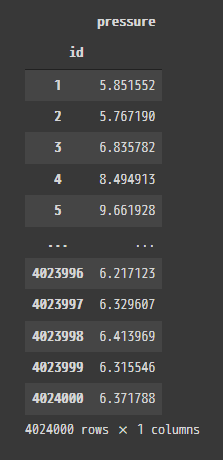

In [ ]:
!kaggle competitions submit -c ventilator-pressure-prediction -f submission.csv -m "Message"